In [ ]:
from numpy.random import uniform
from sys import argv, stdin, stdout, stderr
import pde
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph
import numpy as np
import os
import tempfile
import numpy.linalg as npl
from concurrent.futures import ThreadPoolExecutor
from matplotlib import pyplot as plt
from pdefind import *
import random as r
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [2]:
def convert_to_list(mat,des_len):
    return [mat[i*500:(i+1)*500,:] for i in range(des_len)]

FNU1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNU1.txt')
FNB1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNB1.txt')
FPU1 = np.loadtxt('/scratch/martinaperez/ABM_data/FPU1.txt')

u = convert_to_list(FNU1,1000)
b = convert_to_list(FNB1,1000)
p = convert_to_list(FPU1,1000)

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

Figure 2

In [4]:
FNU1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNU1.txt')
FNB1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNB1.txt')
FPU1 = np.loadtxt('/scratch/martinaperez/ABM_data/FPU1.txt')

u = convert_to_list(FNU1,1000)
b = convert_to_list(FNB1,1000)
p = convert_to_list(FPU1,1000)

In [5]:
FNU50 = np.loadtxt('/scratch/martinaperez/ABM_data/FNU50.txt')
FNB50 = np.loadtxt('/scratch/martinaperez/ABM_data/FNB50.txt')
FPU50 = np.loadtxt('/scratch/martinaperez/ABM_data/FPU50.txt')

u50 = convert_to_list(FNU50,250)
b50 = convert_to_list(FNB50,250)
p50 = convert_to_list(FPU50,250)

In [6]:
class libraryPDE(PDEBase):
    
    def __init__(self, params):
        self.params = params
        
    def evolution_rate(self, state, t=0):
        assert state.grid.dim == 1
        grad_x = state.gradient("natural")[0]
        c= self.params
        return c[0] + c[1] * state + c[2] * (state**2) + c[3] * grad_x + c[4] * state * grad_x + c[5] * (state**2) * grad_x + c[6] * state.laplace("natural") + c[7] * state * state.laplace("natural") + c[8] * (state**2) * state.laplace("natural")

def compute_a(data):
    l = data.shape[1]
    return [np.count_nonzero(data[j,:])/l for j in range(9)]
    
def integrate(params,IC):
    grid = CartesianGrid([[0, 200]], 200)
    field = ScalarField(grid, IC)  
    storage = MemoryStorage()
    eq = libraryPDE(params)
    return eq.solve(field, t_range=250, dt =0.5,tracker=storage.tracker(0.1)).data

def t_integrate(params,IC,t):
    grid = CartesianGrid([[0, 200]], 200)
    field = ScalarField(grid, IC)  
    storage = MemoryStorage()
    eq = libraryPDE(params)
    return eq.solve(field, t_range=t, dt =0.5,tracker=storage.tracker(0.1)).data

In [7]:
I= np.zeros(200)
I[95:105] = 1.0

In [8]:
unbiased_params = [0,0,0,0,0,0,0.25,0,0]
biased_params = [0,0,0,-0.0375,0.075,0,0.25,0,0]
prolif_params = [0,0.001,-0.001,0,0,0,0.25,0,0]

un25 = t_integrate(unbiased_params,I,50)
un150 = t_integrate(unbiased_params,I,300)
un499 = t_integrate(unbiased_params,I,998)

bi25 = t_integrate(biased_params,I,50)
bi150 = t_integrate(biased_params,I,300)
bi499 = t_integrate(biased_params,I,998)

pr25 = t_integrate(prolif_params,I,50)
pr150 = t_integrate(prolif_params,I,300)
pr499 = t_integrate(prolif_params,I,998)

Text(0, 0.5, '$c(x,t)$')

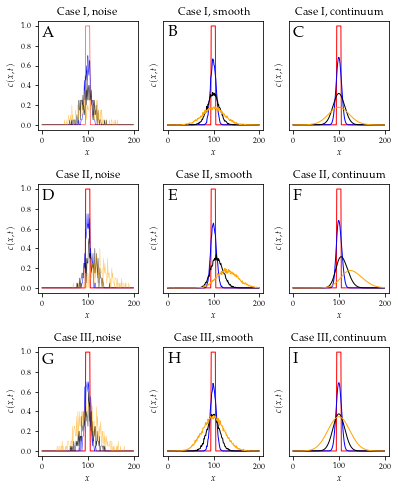

In [9]:
fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(6.3,8),gridspec_kw={'wspace':0.25,'hspace':0.5})
linewidth=1
axes[0,0].plot(I,color='red',linewidth=0.5*linewidth)
axes[0,0].plot(u[90][25],color='blue',linewidth=0.5*linewidth,alpha=0.9)
axes[0,0].plot(u[90][150],color='black',linewidth=0.5*linewidth,alpha=0.8)
axes[0,0].plot(u[90][499],color='orange',linewidth=0.5*linewidth,alpha=0.6)
axes[0,0].set_title('Case I, noise')
axes[0,0].text(0.05, 1, 'A', fontsize=16, fontweight='bold', va='top')
axes[0,0].set_xlabel(r'$x$')
axes[0,0].set_ylabel(r'$c(x,t)$')

axes[1,0].plot(I,color='red',linewidth=linewidth)
axes[1,0].plot(b[90][25],color='blue',linewidth=0.5*linewidth,alpha=0.9)
axes[1,0].plot(b[90][150],color='black',linewidth=0.5*linewidth,alpha=0.8)
axes[1,0].plot(b[90][499],color='orange',linewidth=0.5*linewidth,alpha=0.6)
axes[1,0].set_title('Case II, noise')
axes[1,0].text(0.05, 1, 'D', fontsize=16, fontweight='bold', va='top')
axes[1,0].set_xlabel(r'$x$')
axes[1,0].set_ylabel(r'$c(x,t)$')

axes[2,0].plot(I,color='red',linewidth=linewidth)
axes[2,0].plot(p[90][25],color='blue',linewidth=0.5*linewidth,alpha=0.9)
axes[2,0].plot(p[90][150],color='black',linewidth=0.5*linewidth,alpha=0.8)
axes[2,0].plot(p[90][499],color='orange',linewidth=0.5*linewidth,alpha=0.6)
axes[2,0].set_title('Case III, noise')
axes[2,0].text(0.05, 1, 'G', fontsize=16, fontweight='bold', va='top')
axes[2,0].set_xlabel(r'$x$')
axes[2,0].set_ylabel(r'$c(x,t)$')

axes[0,1].plot(I,color='red',linewidth=linewidth)
axes[0,1].plot(u50[90][25],color='blue',linewidth=linewidth)
axes[0,1].plot(u50[90][150],color='black',linewidth=linewidth)
axes[0,1].plot(u50[90][499],color='orange',linewidth=linewidth)
axes[0,1].set_title('Case I, smooth')
axes[0,1].set_yticks([])
axes[0,1].text(0.05, 1, 'B', fontsize=16, fontweight='bold', va='top')
axes[0,1].set_xlabel(r'$x$')
axes[0,1].set_ylabel(r'$c(x,t)$')

axes[1,1].plot(I,color='red',linewidth=linewidth)
axes[1,1].plot(b50[90][25],color='blue',linewidth=linewidth)
axes[1,1].plot(b50[90][150],color='black',linewidth=linewidth)
axes[1,1].plot(b50[90][499],color='orange',linewidth=linewidth)
axes[1,1].set_title('Case II, smooth')
axes[1,1].set_yticks([])
axes[1,1].text(0.05, 1, 'E', fontsize=16, fontweight='bold', va='top')
axes[1,1].set_xlabel(r'$x$')
axes[1,1].set_ylabel(r'$c(x,t)$')

axes[2,1].plot(I,color='red',linewidth=linewidth)
axes[2,1].plot(p50[90][25],color='blue',linewidth=linewidth)
axes[2,1].plot(p50[90][150],color='black',linewidth=linewidth)
axes[2,1].plot(p50[90][499],color='orange',linewidth=linewidth)
axes[2,1].set_title('Case III, smooth')
axes[2,1].set_yticks([])
axes[2,1].text(0.05, 1, 'H', fontsize=16, fontweight='bold', va='top')
axes[2,1].set_xlabel(r'$x$')
axes[2,1].set_ylabel(r'$c(x,t)$')

axes[0,2].plot(I,color='red',linewidth=linewidth)
axes[0,2].plot(un25,color='blue',linewidth=linewidth)
axes[0,2].plot(un150,color='black',linewidth=linewidth)
axes[0,2].plot(un499,color='orange',linewidth=linewidth)
axes[0,2].set_title('Case I, continuum')
axes[0,2].set_yticks([])
axes[0,2].text(0.05, 1, 'C', fontsize=16, fontweight='bold', va='top')
axes[0,2].set_xlabel(r'$x$')
axes[0,2].set_ylabel(r'$c(x,t)$')

axes[1,2].plot(I,color='red',linewidth=linewidth)
axes[1,2].plot(bi25,color='blue',linewidth=linewidth)
axes[1,2].plot(bi150,color='black',linewidth=linewidth)
axes[1,2].plot(bi499,color='orange',linewidth=linewidth)
axes[1,2].set_title('Case II, continuum')
axes[1,2].set_yticks([])
axes[1,2].text(0.05, 1, 'F', fontsize=16, fontweight='bold', va='top')
axes[1,2].set_xlabel(r'$x$')
axes[1,2].set_ylabel(r'$c(x,t)$')

axes[2,2].plot(I,color='red',linewidth=linewidth)
axes[2,2].plot(pr25,color='blue',linewidth=linewidth)
axes[2,2].plot(pr150,color='black',linewidth=linewidth)
axes[2,2].plot(pr499,color='orange',linewidth=linewidth)
axes[2,2].set_title('Case III, continuum')
axes[2,2].set_yticks([])
axes[2,2].text(0.05, 1, 'I', fontsize=16, fontweight='bold', va='top')
axes[2,2].set_xlabel(r'$x$')
axes[2,2].set_ylabel(r'$c(x,t)$')

#plt.savefig('data_traces',dpi=1000)

Figure 3

In [10]:
FNU_coeffs1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNU_coeffs1.txt')
FNU_coeffs50 = np.loadtxt('/scratch/martinaperez/ABM_data/FNU_coeffs50.txt')
FNB_coeffs1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNB_coeffs1.txt')
FNB_coeffs50 = np.loadtxt('/scratch/martinaperez/ABM_data/FNB_coeffs50.txt')
FPU_coeffs1 = np.loadtxt('/scratch/martinaperez/ABM_data/reckless_FPU_coeffs1.txt')
FPU_coeffs50 = np.loadtxt('/scratch/martinaperez/ABM_data/reckless_FPU_coeffs50.txt')

Text(0, 0.5, '$c_{u\\cdot u_{xx}}$')

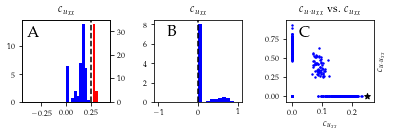

In [11]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(6.3,1.5),gridspec_kw={'wspace':0.5,'hspace':1})
axes[0].hist(FNU_coeffs1[6,:],bins=30,color='blue',density=True,range=[-0.4,0.4])
ax0_secondary = axes[0].twinx()
ax0_secondary.hist(FNU_coeffs50[6,:],bins=30,color='red',density=True,range=[-0.4,0.4])
axes[0].axvline(0.25,color='black',linestyle='dashed')
axes[0].set_title(r'$c_{u_{xx}}$')
axes[0].text(0.05, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)

axes[1].hist(FNU_coeffs1[7,:],bins=20,color='blue',density=True,range=[-1,1])
axes[1].axvline(0,color='black',linestyle='dashed')
axes[1].set_title(r'$c_{u_{xx}}$')
axes[1].text(0.15, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)


axes[2].scatter(FNU_coeffs1[6,:],FNU_coeffs1[7,:],color='blue',s=2,marker='o')
axes[2].scatter(0.25,0,marker='*',color='black')
axes[2].set_title(r'$c_{u\cdot u_{xx}}$ vs. $c_{u_{xx}}$')
axes[2].text(0.15, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)
axes[2].set_xlabel(r'$c_{u_{xx}}$')
axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel(r'$c_{u\cdot u_{xx}}$')


#plt.savefig('CaseI_hists',dpi=1000,bbox_inches='tight')

Figure 4

Text(0.28, 0.8, 'C')

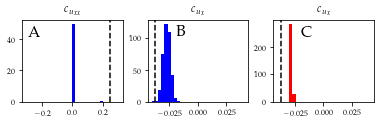

In [12]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(6.3,1.5),gridspec_kw={'wspace':0.25,'hspace':0.3})

axes[0].hist(FNB_coeffs1[6,:],color='blue',bins=30,density=True,range=[-0.3,0.3])
axes[0].axvline(0.25,color='black',linestyle='dashed')
axes[0].set_title(r'$c_{u_{xx}}$')
axes[0].text(0.06, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)

axes[1].hist(FNB_coeffs1[3,:],bins=30,color='blue',density=True,range=[-0.04,0.04])
axes[1].axvline(-0.0375,color='black',linestyle='dashed')
axes[1].set_title(r'$c_{u_{x}}$')
axes[1].text(0.28, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)

axes[2].hist(FNB_coeffs50[3,:],bins=25,color='red',density=True,range=[-0.04,0.04])
axes[2].axvline(-0.0375,color='black',linestyle='dashed')
axes[2].set_title(r'$c_{u_{x}}$')
axes[2].text(0.28, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)

#plt.savefig('CaseII_hists',dpi=1000,bbox_inches='tight')

Figure 5

Text(0.11, 0.8, 'D')

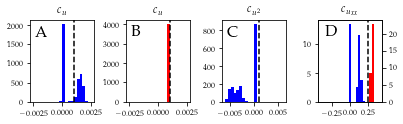

In [13]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(6.3,1.5),gridspec_kw={'wspace':0.5,'hspace':0.3})

axes[0].hist(FPU_coeffs1[1,:],color='blue',density=True,range=[-0.0025,0.0025],bins=20)
axes[0].axvline(0.001,color='black',linestyle='dashed')
axes[0].set_title(r'$c_{u}$')
axes[0].text(0.075, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)

axes[1].hist(FPU_coeffs50[1,:],color='red',density=True,range=[-0.0025,0.0025],bins=20)
axes[1].set_title(r'$c_{u}$')
axes[1].axvline(0.001,color='black',linestyle='dashed')
axes[1].text(0.075, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)

axes[2].hist(FPU_coeffs1[2,:],color='blue',density=True,range=[-0.006,0.006],bins=20)
axes[2].axvline(0.001,color='black',linestyle='dashed')
axes[2].set_title(r'$c_{u^2}$')
axes[2].text(0.075, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)

axes[3].hist(FPU_coeffs1[6,:],bins=25,color='blue',density=True,range=[-0.4,0.4])
ax2_secondary = axes[3].twinx()
ax2_secondary.hist(FPU_coeffs50[6,:],bins=25,color='red',density=True,range=[-0.4,0.4])
axes[3].axvline(0.25,color='black',linestyle='dashed')
axes[3].set_title(r'$c_{u_{xx}}$')
axes[3].text(0.11, 0.8, 'D', fontsize=16, fontweight='bold',transform=axes[3].transAxes)
#plt.savefig('CaseIII_hists',dpi=1000,bbox_inches='tight')

Figure 6

In [14]:
l0_05 = np.loadtxt('/scratch/martinaperez/ABM_data/lambda_0-05.txt')
l0_1 = np.loadtxt('/scratch/martinaperez/ABM_data/lambda_0-1.txt')
l0_5 = np.loadtxt('/scratch/martinaperez/ABM_data/lambda_0-5.txt')

Text(0, 0.5, '$c_{u\\cdot u_{xx}}$')

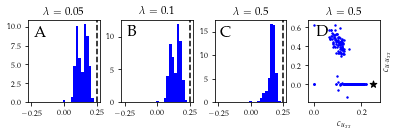

In [15]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(6.3,1.5),gridspec_kw={'wspace':0.3,'hspace':0.3})

axes[0].hist(l0_05[6,:],color='blue',density=True,bins=25,range=[-0.25,0.25])
axes[0].set_title(r'$\lambda=0.05$')
axes[0].text(0.075, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)
axes[0].axvline(0.25,color='black',linestyle='dashed')

axes[1].hist(l0_1[6,:],color='blue',density=True,bins=25,range=[-0.25,0.25])
axes[1].set_title(r'$\lambda=0.1$')
axes[1].text(0.075, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)
axes[1].axvline(0.25,color='black',linestyle='dashed')

axes[2].hist(l0_5[6,:],color='blue',density=True,bins=25,range=[-0.25,0.25])
axes[2].set_title(r'$\lambda=0.5$')
axes[2].text(0.075, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)
axes[2].axvline(0.25,color='black',linestyle='dashed')

axes[3].scatter(l0_5[6,:],l0_5[7,:],color='blue',s=2)
axes[3].scatter(0.25,0,marker='*',color='black',s=50)
axes[3].set_title(r'$\lambda=0.5$')
axes[3].text(0.11, 0.8, 'D', fontsize=16, fontweight='bold',transform=axes[3].transAxes)
axes[3].set_xlabel(r'$c_{u_{xx}}$')
axes[3].yaxis.set_label_position("right")
axes[3].set_ylabel(r'$c_{u\cdot u_{xx}}$')

#plt.savefig('CV_hists',dpi=1000,bbox_inches='tight')

Figure 7

In [16]:
u_good_params = np.array([0,0,0,0,0,0,0.10359399,0.26028285,0])
u_bad_params = np.array([0,0,0,0,0,0,0,0,1.51713414])
u_ground_truth = np.array([0,0,0,0,0,0,0.25,0,0])
ub_good = integrate(u_good_params,I)
ub_bad = integrate(u_bad_params,I)
ub_ground_truth = integrate(u_ground_truth,I)

b_good_params = np.array([0,0,0,-0.02636034,0,0,0.19909815,0,0])
b_bad_params = np.array([0,0,0,0,0,0,0,0.64123767,0])
b_ground_truth = np.array([0,0,0,-0.0375,0.075,0,0.25,0,0])
bi_good = integrate(b_good_params,I)
bi_bad = integrate(b_bad_params,I)
bi_ground_truth = integrate(b_ground_truth,I)

p_good_params= np.array([0,0,0,0,0,0,0.1219209,0,0])
p_bad_params = np.array([0,0.0001295,0,0,0,0,0,0,0])
p_ground_truth =np.array([0,0.001,-0.001,0,0,0,0.25,0,0])
pr_good = integrate(p_good_params,I)
pr_bad = integrate(p_bad_params,I)
pr_ground_truth = integrate(p_ground_truth,I)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


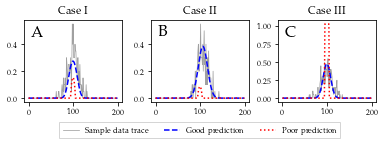

In [17]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(6.3,1.5),gridspec_kw={'wspace':0.3,'hspace':0.3})

axes[0].plot(u[90][125],color='grey',linewidth=0.75,alpha=0.75,label='Sample data trace')
#axes[0].plot(ub_ground_truth)
axes[0].plot(ub_good,linestyle='--',color='blue',label='Good prediction')
axes[0].plot(ub_bad,linestyle=':',color='red',label='Poor prediction')
axes[0].set_title('Case I')
axes[0].text(0.075, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)

axes[1].plot(b[90][125],color='grey',linewidth=0.75,alpha=0.75)
axes[1].plot(bi_good,linestyle='--',color='blue')
axes[1].plot(bi_bad,linestyle=':',color='red')
axes[1].set_title('Case II')
axes[1].text(0.075, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)

axes[2].plot(p[90][125],color='grey',linewidth=0.75,alpha=0.75)
axes[2].plot(pr_good,linestyle='--',color='blue')
axes[2].plot(pr_bad,linestyle=':',color='red')
axes[2].set_title('Case III')
axes[2].text(0.075, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)

handles, labels = axes[0].get_legend_handles_labels()
axes[1].legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3)

#plt.savefig('Comparing_predictions',dpi=1000,bbox_inches='tight')

Figure 8 and Figure S14

In [ ]:
from numpy import vectorize

def err(x,y):
    p = [0,0,0,0,0,0,x,y,0]
    pred = integrate(p,I)
    return npl.norm(pred-FNU_ave[125])

v_err = vectorize(err)

def der_err_ave(x,y):
    fit_ave = x*uxx_ave + y*uuxx_ave
    return npl.norm(observed_ave-fit_ave)

In [ ]:
x = np.linspace(0, 0.35, 50)
y = np.linspace(0, 0.75, 50)

X, Y = np.meshgrid(x, y)
Z = v_err(X, Y)

In [18]:
x = np.linspace(0, 0.35, 50)
y = np.linspace(0, 0.75, 50)
X, Y = np.meshgrid(x, y)
Z = np.loadtxt('L2errors_ave.txt')
Z4 = np.loadtxt('L2der_errs_ave.txt')
Z2= np.loadtxt('L2errors_single.txt')
Z3 = np.loadtxt('L2der_errs_single.txt')

In [19]:
FNU_coeffs1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNU_coeffs1.txt')
FNU_coeffs1_clipped = FNU_coeffs1[:,np.where(FNU_coeffs1[7,:]<0.75)]

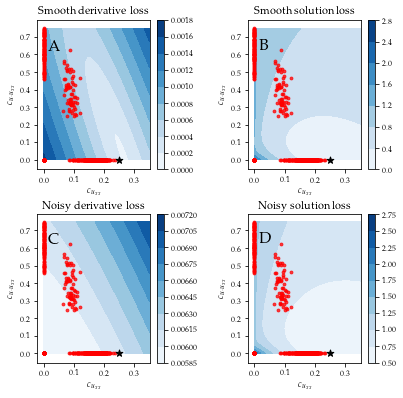

In [20]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(6.3,6.3),gridspec_kw={'wspace':0.5,'hspace':0.3})

axes[0,0].text(0.1, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0,0].transAxes)
derplot = axes[0,0].contourf(X,Y,Z4,cmap='Blues')
axes[0,0].set_xlabel(r'$c_{u_{xx}}$')
axes[0,0].set_ylabel(r'$c_{u\cdot u_{xx}}$')
axes[0,0].set_title(r'Smooth derivative loss')
axes[0,0].scatter(FNU_coeffs1_clipped[6,:],FNU_coeffs1_clipped[7,:],s=8,color='r',alpha=0.75)
axes[0,0].scatter(0.25,0,marker='*',color='black',s=50)
plt.colorbar(derplot,ax=axes[0,0])

axes[0,1].text(0.1, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[0,1].transAxes)
solplot = axes[0,1].contourf(X,Y,Z,cmap='Blues')
axes[0,1].set_xlabel(r'$c_{u_{xx}}$')
axes[0,1].set_ylabel(r'$c_{u\cdot u_{xx}}$')
axes[0,1].set_title(r'Smooth solution loss ')
axes[0,1].scatter(FNU_coeffs1_clipped[6,:],FNU_coeffs1_clipped[7,:],s=8,color='r',alpha=0.75)
axes[0,1].scatter(0.25,0,marker='*',color='black',s=50)
plt.colorbar(solplot,ax=axes[0,1])

axes[1,0].text(0.1, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[1,0].transAxes)
nderplot = axes[1,0].contourf(X,Y,Z3,cmap='Blues')
axes[1,0].set_xlabel(r'$c_{u_{xx}}$')
axes[1,0].set_ylabel(r'$c_{u\cdot u_{xx}}$')
axes[1,0].set_title(r'Noisy derivative loss')
axes[1,0].scatter(FNU_coeffs1_clipped[6,:],FNU_coeffs1_clipped[7,:],s=8,color='r',alpha=0.75)
axes[1,0].scatter(0.25,0,marker='*',color='black',s=50)
plt.colorbar(nderplot,ax=axes[1,0])

axes[1,1].text(0.1, 0.8, 'D', fontsize=16, fontweight='bold',transform=axes[1,1].transAxes)
nsolplot = axes[1,1].contourf(X,Y,Z2,cmap='Blues')
axes[1,1].set_xlabel(r'$c_{u_{xx}}$')
axes[1,1].set_ylabel(r'$c_{u\cdot u_{xx}}$')
axes[1,1].set_title(r'Noisy solution loss ')
axes[1,1].scatter(FNU_coeffs1_clipped[6,:],FNU_coeffs1_clipped[7,:],s=8,color='r',alpha=0.75)
axes[1,1].scatter(0.25,0,marker='*',color='black',s=50)
plt.colorbar(nsolplot,ax=axes[1,1])


#plt.savefig('loss_landscape_comparisons',dpi=1000,bbox_inches='tight')

Figure 9

In [21]:
from numpy.random import normal, uniform

nsamples = 100000
prior_sample = []

a_diff = 0.79
a_udiff = 0.14
diffMean = 0.17
udiffMean = 0.64
diffSD = 0.021
udiffSD = 0.095

for i in tqdm(range(nsamples)):
    t1 = uniform(low=0,high=1)
    t2 = uniform(low=0,high=1)

    diff_sampled = normal(loc=diffMean,scale=diffSD)
    udiff_sampled = normal(loc=udiffMean,scale=udiffSD)

    if t1>a_diff: #draw from just diffusion coefficient
        udiff_sampled =0

    elif t2>a_udiff: #draw from just u*diffusion coefficient
        diff_sampled = 0
    prior_sample.append(np.array([diff_sampled,udiff_sampled]))

u_prior_matrix = np.zeros((nsamples,2))

for i in tqdm(range(nsamples)):
    u_prior_matrix[i,:] = prior_sample[i]
   
a_diff = 0.012 #from table
diffMean = np.mean(FNB_coeffs1[6,np.where(FNB_coeffs1[6,:]>0)[0]]) #=0.185
diffSD = np.std(FNB_coeffs1[6,np.where(FNB_coeffs1[6,:]>0)[0]]) #=0.0205
uxMean = np.mean(FNB_coeffs1[3,:]) #=-0.0273
uxSD = np.std(FNB_coeffs1[3,:]) #=0.00311

prior_sample = []

for i in tqdm(range(nsamples)):
    diffDraw = uniform(low=0,high=1)
    uxDraw = uniform(low=0,high=1)
    ux_sampled = normal(loc = uxMean,scale=uxSD)

    if diffDraw < a_diff:
        diff_sampled = normal(loc = diffMean,scale=diffSD)
    else: 
        diff_sampled = 0
    
    prior_sample.append(np.array([ux_sampled,diff_sampled]))

b_prior_matrix = np.zeros((nsamples,2))

for i in tqdm(range(nsamples)):
    b_prior_matrix[i,:] = prior_sample[i]

a_u = 0.659
uMean = np.mean(FPU_coeffs1[1,np.where(FPU_coeffs1[1,:]>0)]) # =0.00119
uSD = np.std(FPU_coeffs1[1,np.where(FPU_coeffs1[1,:]>0)]) #=0.000662
a_u2 = 0.482
u2Mean = np.mean(FPU_coeffs1[2,np.where(FPU_coeffs1[2,:]!=0)]) #=0.00383
u2SD = np.std(FPU_coeffs1[2,np.where(FPU_coeffs1[2,:]!=0)]) #= 0.00102
a_diff = 0.571
diffMean = np.mean(FPU_coeffs1[6,np.where(FPU_coeffs1[6,:]!=0)]) #=0.1303
diffSD = np.std(FPU_coeffs1[6,np.where(FPU_coeffs1[6,:]!=0)]) #=0.0174

prior_sample = []
for i in tqdm(range(nsamples)):
    uDraw = uniform(low=0,high=1)
    u2Draw = uniform(low=0,high=1)
    diffDraw = uniform(low=0,high=1)

    if uDraw < a_u:
        u_sampled = normal(loc = uMean,scale=uSD)
    else: 
        u_sampled = 0

    if u2Draw < a_u2:
        u2_sampled = normal(loc = u2Mean,scale=u2SD)
    else: 
        u2_sampled = 0

    if diffDraw < a_diff:
        diff_sampled = normal(loc = diffMean,scale=diffSD)
    else: 
        diff_sampled = 0
    
    prior_sample.append(np.array([u_sampled,u2_sampled,diff_sampled]))

p_prior_matrix = np.zeros((nsamples,3))

for i in tqdm(range(nsamples)):
    p_prior_matrix[i,:] = prior_sample[i]    

100%|██████████| 100000/100000 [00:00<00:00, 1488143.96it/s]


In [22]:
FNU_broad = np.genfromtxt('NEW_FNU_broad_posterior.txt',delimiter=',')
FNU_posterior = np.genfromtxt('NEW_FNU_PDE_posterior.txt',delimiter=',')

FNB_broad = np.genfromtxt('FNB_broad_posterior.txt',delimiter=',')
FNB_posterior = np.genfromtxt('NEW_FNB_broad_posterior.txt',delimiter=',')

FPU_broad = np.genfromtxt('NEW_FPU_PDE_posterior.txt',delimiter=',')
FPU_posterior = np.genfromtxt('NEW_FPU_broad_posterior.txt',delimiter=',')

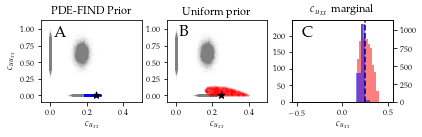

In [23]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(6.3,1.5),gridspec_kw={'wspace':0.25,'hspace':0.3})
axes[0].scatter(u_prior_matrix[:,0],u_prior_matrix[:,1],s=2,color='grey',alpha=0.005,label='Prior')
axes[0].scatter(FNU_posterior[:,0],FNU_posterior[:,1],s=2,color='blue')
axes[0].scatter(0.25,0,marker='*',color='black',s=50)
axes[0].set_title('PDE-FIND Prior')
axes[0].text(0.125, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)
axes[0].set_xlim([-0.05,0.5])
axes[0].set_xlabel(r'$c_{u_{xx}}$')
axes[0].set_ylabel(r'$c_{uu_{xx}}$')

axes[1].scatter(u_prior_matrix[:,0],u_prior_matrix[:,1],s=2,color='grey',alpha=0.005,label='Prior')
axes[1].scatter(FNU_broad[:,0],FNU_broad[:,1],s=2,color='red',alpha=0.05)
axes[1].scatter(0.25,0,marker='*',color='black',s=50)
axes[1].set_title('Uniform prior')
axes[1].text(0.125, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)
axes[1].set_xlim([-0.05,0.5])
axes[1].set_xlabel(r'$c_{u_{xx}}$')

axes[2].hist(FNU_broad[:,0],color='red',alpha=0.5)
#axes[2].hist(FNU_posterior[:,0],color='blue',alpha=0.5,range=[-0.5,0.5],bins=25)
ax3=axes[2].twinx()
ax3.hist(FNU_posterior[:,0],color='blue',alpha=0.5,range=[-0.5,0.5],bins=20)
axes[2].axvline(0.25,color='black',linestyle='dashed')
axes[2].text(0.1, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)
axes[2].set_title(r'$c_{u_{xx}}$ marginal')
axes[2].set_xlabel(r'$c_{u_{xx}}$')
plt.savefig('CaseIposteriors',dpi=1000,bbox_inches='tight')

Figure 10

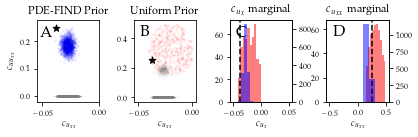

In [24]:
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(6.3,1.5),gridspec_kw={'wspace':0.55,'hspace':0.35})
axes[0].scatter(b_prior_matrix[:,0],b_prior_matrix[:,1],s=2,color='grey',alpha=0.005,label='Prior')
axes[0].scatter(FNB_posterior[~np.isnan(FNB_posterior[:,0]),0],FNB_posterior[~np.isnan(FNB_posterior[:,0]),1],s=2,color='blue',alpha=0.05)
axes[0].scatter(-0.0375,0.25,marker='*',color='black',s=50)
axes[0].set_title('PDE-FIND Prior')
axes[0].text(0.05, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)
axes[0].set_xlabel(r'$c_{u_{xx}}$')
axes[0].set_ylabel(r'$c_{uu_{xx}}$')

axes[1].scatter(b_prior_matrix[:,0],b_prior_matrix[:,1],s=2,color='grey',alpha=0.005,label='Prior')
axes[1].scatter(FNB_broad[:,0],FNB_broad[:,1],s=2,color='red',alpha=0.05)
axes[1].scatter(-0.0375,0.25,marker='*',color='black',s=50)
axes[1].set_title('Uniform Prior')
axes[1].text(0.1, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)
axes[1].set_xlabel(r'$c_{u_{xx}}$')

axes[2].hist(FNB_broad[:,0],color='red',alpha=0.5)
ax2 = axes[2].twinx()
ax2.hist(FNB_posterior[~np.isnan(FNB_posterior[:,0]),0],color='blue',alpha=0.5,range=[-0.05,0.05],bins=20)
axes[2].axvline(-0.0375,color='black',linestyle='dashed')
axes[2].text(0.1, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)
axes[2].set_title(r'$c_{u_x}$ marginal')
axes[2].set_xlabel(r'$c_{u_{x}}$')

axes[3].hist(FNB_broad[:,1],color='red',alpha=0.5)
ax3 = axes[3].twinx()
ax3.hist(FNB_posterior[~np.isnan(FNB_posterior[:,0]),1],color='blue',alpha=0.5,range=[-0.5,0.5])
axes[3].axvline(0.25,color='black',linestyle='dashed')
axes[3].set_title(r'$c_{u_{xx}}$ marginal')
axes[3].set_xlabel(r'$c_{u_{xx}}$')
axes[3].text(0.1, 0.8, 'D', fontsize=16, fontweight='bold',transform=axes[3].transAxes)
plt.savefig('CaseIIposteriors',dpi=1000,bbox_inches='tight')

Figure 11

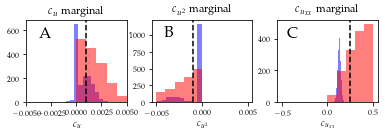

In [44]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(6.3,1.5),gridspec_kw={'wspace':0.25,'hspace':0.3})
axes[0].hist(FPU_posterior[:,0],color='blue',alpha=0.5)
axes[0].hist(FPU_broad[:,0],color='red',alpha=0.5,range=[-0.005,0.005])
axes[0].set_title(r'$c_u$ marginal')
axes[0].text(0.125, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)
axes[0].set_xlabel(r'$c_{u}$')
axes[0].axvline(0.001,color='black',linestyle='dashed')
axes[0].set_xlim([-0.005,0.005])

axes[1].hist(-FPU_posterior[:,1],color='blue',alpha=0.5)
axes[1].hist(-FPU_broad[:,1],color='red',alpha=0.5,range=[-0.005,0.005])
axes[1].text(0.125, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)
axes[1].set_title(r'$c_{u^2}$ marginal')
axes[1].set_xlabel(r'$c_{u^2}$')
axes[1].axvline(-0.001,color='black',linestyle='dashed')

axes[2].hist(FPU_posterior[:,2],color='blue',alpha=0.5)
axes[2].hist(FPU_broad[:,2],color='red',alpha=0.5,range=[-0.5,0.5])
axes[2].text(0.1, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)
axes[2].set_title(r'$c_{u_{xx}}$ marginal')
axes[2].set_xlabel(r'$c_{u_{xx}}$')
axes[2].axvline(0.25,color='black',linestyle='dashed')
plt.savefig('CaseIIIposteriors_reduced',dpi=1000,bbox_inches='tight')

Figure 12

In [ ]:
nsample = FNU_posterior.shape[0]
posterior = np.zeros((nsample,200))

for i in tqdm(range(nsample)):
    params = [0,0,0,0,0,0,FNU_posterior[i,0],FNU_posterior[i,1],0]
    posterior[i,:] = integrate(params,I)

upper_bound = np.zeros(200)
lower_bound = np.zeros(200)

for i in range(200):
    lower_bound[i], upper_bound[i] = np.quantile(posterior[:,i],[0,1])

u_upper_bound = upper_bound
u_lower_bound = lower_bound

In [37]:
FNU_ave = np.zeros(u[0].shape)

for i in range(len(b)):
    FNU_ave = FNU_ave + u[i]/1000   
    
FNB_ave = np.zeros(b[0].shape)

for i in range(len(b)):
    FNB_ave = FNB_ave + b[i]/1000      
    
FPU_ave = np.zeros(p[0].shape)

for i in range(len(p)):
    FPU_ave = FPU_ave + p[i]/1000      

In [ ]:
nsample = FNB_posterior.shape[0]
posterior = np.zeros((nsample,200))

for i in tqdm(range(nsample)):
    params = [0,0,0,FNB_posterior[i,0],0,0,FNB_posterior[i,1],0,0]
    posterior[i,:] = integrate(params,I)

upper_bound = np.zeros(200)
lower_bound = np.zeros(200)

for i in range(200):
    lower_bound[i], upper_bound[i] = np.quantile(posterior[:,i],[0,1])

b_upper_bound = upper_bound
b_lower_bound = lower_bound

In [ ]:
nsample = FNU_posterior.shape[0]
posterior = np.zeros((nsample,200))

for i in tqdm(range(nsample)):
    params = [0,FPU_posterior[i,0],FPU_posterior[i,1],0,0,0,FPU_posterior[i,2],0,0]
    posterior[i,:] = integrate(params,I)

upper_bound = np.zeros(200)
lower_bound = np.zeros(200)

for i in range(200):
    lower_bound[i], upper_bound[i] = np.quantile(posterior[:,i],[0,1])

    
p_upper_bound = upper_bound
p_lower_bound = lower_bound    

In [ ]:
np.savetxt('NEW_u_lower_bound.txt',u_lower_bound)
np.savetxt('NEW_u_upper_bound.txt',u_upper_bound)

np.savetxt('NEW_b_lower_bound.txt',b_lower_bound)
np.savetxt('NEW_b_upper_bound.txt',b_upper_bound)

np.savetxt('NEW_p_lower_bound.txt',p_lower_bound)
np.savetxt('NEW_p_upper_bound.txt',p_upper_bound)

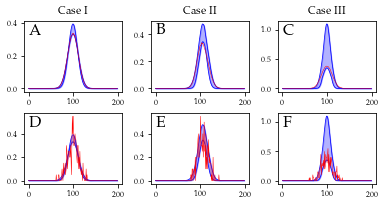

In [38]:
u_lower_bound = np.loadtxt('NEW_u_lower_bound.txt')
u_upper_bound= np.loadtxt('NEW_u_upper_bound.txt')

b_lower_bound = np.loadtxt('NEW_b_lower_bound.txt')
b_upper_bound = np.loadtxt('NEW_b_upper_bound.txt')

p_lower_bound = np.loadtxt('NEW_p_lower_bound.txt')
p_upper_bound = np.loadtxt('NEW_p_upper_bound.txt')

for i in range(200):
    b_lower_bound[i] = max(b_lower_bound[i],0)
    b_upper_bound[i] = max(b_upper_bound[i],0)

fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(6.3,3),gridspec_kw={'wspace':0.3,'hspace':0.3})

linewidth = 0.75
datalinewidth = 0.5

axes[0,0].text(0.05, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0,0].transAxes)
axes[0,0].plot(u_lower_bound,linewidth=linewidth,color='blue')
axes[0,0].plot(u_upper_bound,linewidth=linewidth,color='blue')
axes[0,0].fill_between(range(200),u_lower_bound,u_upper_bound, alpha=0.3,color='blue')
axes[0,0].plot(FNU_ave[125,:],color='red',linewidth=datalinewidth,alpha=1)
axes[0,0].set_title('Case I')

axes[0,1].text(0.05, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[0,1].transAxes)
axes[0,1].plot(b_lower_bound,linewidth=linewidth,color='blue')
axes[0,1].plot(b_upper_bound,linewidth=linewidth,color='blue')
axes[0,1].fill_between(range(200),b_lower_bound,b_upper_bound, alpha=0.3,color='blue')
axes[0,1].plot(FNB_ave[125,:],color='red',linewidth=datalinewidth,alpha=1)
axes[0,1].set_title('Case II')

axes[0,2].text(0.05, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[0,2].transAxes)
axes[0,2].plot(p_lower_bound,linewidth=linewidth,color='blue')
axes[0,2].plot(p_upper_bound,linewidth=linewidth,color='blue')
axes[0,2].fill_between(range(200),p_lower_bound,p_upper_bound, alpha=0.3,color='blue')
axes[0,2].plot(FPU_ave[125,:],color='red',linewidth=datalinewidth,alpha=1)
axes[0,2].set_title('Case III')


axes[1,0].text(0.05, 0.8, 'D', fontsize=16, fontweight='bold',transform=axes[1,0].transAxes)
axes[1,0].plot(u_lower_bound,linewidth=linewidth,color='blue')
axes[1,0].plot(u_upper_bound,linewidth=linewidth,color='blue')
axes[1,0].fill_between(range(200),u_lower_bound,u_upper_bound, alpha=0.3,color='blue')
axes[1,0].plot(u[90][125,:],color='red',linewidth=datalinewidth,alpha=1)

axes[1,1].text(0.05, 0.8, 'E', fontsize=16, fontweight='bold',transform=axes[1,1].transAxes)
axes[1,1].plot(b_lower_bound,linewidth=linewidth,color='blue')
axes[1,1].plot(b_upper_bound,linewidth=linewidth,color='blue')
axes[1,1].fill_between(range(200),b_lower_bound,b_upper_bound, alpha=0.3,color='blue')
axes[1,1].plot(b[90][125,:],color='red',linewidth=datalinewidth,alpha=1)

axes[1,2].text(0.05, 0.8, 'F', fontsize=16, fontweight='bold',transform=axes[1,2].transAxes)
axes[1,2].plot(p_lower_bound,linewidth=linewidth,color='blue')
axes[1,2].plot(p_upper_bound,linewidth=linewidth,color='blue')
axes[1,2].fill_between(range(200),p_lower_bound,p_upper_bound, alpha=0.3,color='blue')
axes[1,2].plot(p[90][125,:],color='red',linewidth=datalinewidth,alpha=1)

plt.savefig('posterior_check',dpi=1000,bbox_inches='tight')

Figure S1

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(6.3,3),gridspec_kw={'wspace':0.25,'hspace':0.3})
linewidth=1
markersize=7.5
alpha=0.5

axes[0].scatter(range(200),FNU_ave[0,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[0].scatter(range(200),FNU_ave[25,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[0].scatter(range(200),FNU_ave[150,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[0].scatter(range(200),FNU_ave[499,:],marker='*',s=markersize,c='grey',alpha=alpha)

axes[0].plot(I,color='red',linewidth=linewidth)
axes[0].plot(un25,color='blue',linewidth=linewidth)
axes[0].plot(un150,color='black',linewidth=linewidth)
axes[0].plot(un499,color='red',linewidth=linewidth)
axes[0].set_title('Case I')
axes[0].set_yticks([])
axes[0].text(0.05, 1, 'A', fontsize=16, fontweight='bold', va='top')

axes[1].scatter(range(200),FNB_ave[0,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[1].scatter(range(200),FNB_ave[25,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[1].scatter(range(200),FNB_ave[150,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[1].scatter(range(200),FNB_ave[499,:],marker='*',s=markersize,c='grey',alpha=alpha)

axes[1].plot(I,color='red',linewidth=linewidth)
axes[1].plot(bi25,color='blue',linewidth=linewidth)
axes[1].plot(bi150,color='black',linewidth=linewidth)
axes[1].plot(bi499,color='red',linewidth=linewidth)
axes[1].set_title('Case II')
axes[1].set_yticks([])
axes[1].text(0.05, 1, 'B', fontsize=16, fontweight='bold', va='top')

axes[2].scatter(range(200),FPU_ave[0,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[2].scatter(range(200),FPU_ave[25,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[2].scatter(range(200),FPU_ave[150,:],marker='*',s=markersize,c='grey',alpha=alpha)
axes[2].scatter(range(200),FPU_ave[499,:],marker='*',s=markersize,c='grey',alpha=alpha)

axes[2].plot(I,color='red',linewidth=linewidth)
axes[2].plot(pr25,color='blue',linewidth=linewidth)
axes[2].plot(pr150,color='black',linewidth=linewidth)
axes[2].plot(pr499,color='red',linewidth=linewidth)
axes[2].set_title('Case III')
axes[2].set_yticks([])
axes[2].text(0.05, 1, 'C', fontsize=16, fontweight='bold', va='top')

#plt.savefig('PDE_and_data_comparison',dpi=500,bbox_inches='tight')

Figure S2

In [ ]:
FNU_coeffs1 = pd.DataFrame(np.transpose(np.loadtxt('/scratch/martinaperez/ABM_data/FNU_coeffs1.txt')))
FNU_coeffs50 = pd.DataFrame(np.transpose(np.loadtxt('/scratch/martinaperez/ABM_data/FNU_coeffs50.txt')))
FNB_coeffs1 = pd.DataFrame(np.transpose(np.loadtxt('/scratch/martinaperez/ABM_data/FNB_coeffs1.txt')))
FNB_coeffs50 = pd.DataFrame(np.transpose(np.loadtxt('/scratch/martinaperez/ABM_data/FNB_coeffs50.txt')))
FPU_coeffs1 = pd.DataFrame(np.transpose(np.loadtxt('/scratch/martinaperez/ABM_data/reckless_FPU_coeffs1.txt')))
FPU_coeffs50 = pd.DataFrame(np.transpose(np.loadtxt('/scratch/martinaperez/ABM_data/reckless_FPU_coeffs50.txt')))

In [ ]:
sns_plot = sns.pairplot(FNU_coeffs1)
fig = sns_plot.fig
#fig.savefig('pairwise_FNU1') 

Figure S3

In [ ]:
sns_plot = sns.pairplot(FNU_coeffs50)
fig = sns_plot.fig
fig.savefig('pairwise_FNU50') 

Figure S4

In [ ]:
sns_plot = sns.pairplot(FNB_coeffs1)
fig = sns_plot.fig
#fig.savefig('pairwise_FNB1') 

Figure S5

In [ ]:
sns_plot = sns.pairplot(FNB_coeffs50)
fig = sns_plot.fig
fig.savefig('pairwise_FNB50') 

Figure S6

In [ ]:
sns_plot = sns.pairplot(FPU_coeffs1)
fig = sns_plot.fig
fig.savefig('pairwise_FPU1') 

Figure S7

In [ ]:
sns_plot = sns.pairplot(FPU_coeffs50)
fig = sns_plot.fig
fig.savefig('pairwise_FPU50') 

Figure S8

In [ ]:
def convert_to_list(mat,des_len):
    return [mat[i*500:(i+1)*500,:] for i in range(des_len)]

FNU1 = np.loadtxt('/scratch/martinaperez/ABM_data/FNU1.txt')
ud1 = convert_to_list(FNU1,1000)

Z1, E1 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.001)
Z2, E2 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.015)
Z3, E3 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.06)
Z4, E4 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.1)

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(6.3,1.5),gridspec_kw={'wspace':0.3,'hspace':0.3})
alpha = 0.5

axes[0].plot(Z1[:,0],'r*',markersize=1.5,alpha=alpha)
axes[0].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[0].plot(Z1[:,499],'k*',markersize=1.5,alpha=alpha)
axes[0].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[0].set_title(r'$\lambda_2=0.001$')
axes[0].set_ylabel('Density')
axes[0].set_yticks([])
axes[0].text(0.075, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)

axes[1].plot(Z2[:,0],'r*',markersize=1.5,alpha=alpha)
axes[1].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[1].plot(Z2[:,499],'k*',markersize=1.5,alpha=alpha)
axes[1].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[1].set_title(r'$\lambda_2=0.015$')
axes[1].set_yticks([])
axes[1].text(0.075, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)

axes[2].plot(Z3[:,0],'r*',markersize=1.5,alpha=alpha)
axes[2].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[2].plot(Z3[:,499],'k*',markersize=1.5,alpha=alpha)
axes[2].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[2].set_title(r'$\lambda_2=0.06$')
axes[2].set_yticks([])
axes[2].text(0.075, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)


axes[3].plot(Z4[:,0],'r*',markersize=1.5,alpha=alpha)
axes[3].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[3].plot(Z4[:,499],'k*',markersize=1.5,alpha=alpha)
axes[3].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[3].set_title(r'$\lambda_2=0.1$')
axes[3].set_yticks([])
axes[3].text(0.11, 0.8, 'D', fontsize=16, fontweight='bold',transform=axes[3].transAxes)

#plt.savefig('rPCA_traces',dpi=1000,bbox_inches='tight')

Figure S9

In [ ]:
Z1_, E1 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.0175)
Z2_, E2 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.03)
Z3_, E3 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.035)
Z4_, E4 = rp.RobustPCA(np.transpose(ud1[50]), lam_2 = 0.4)

for i in range(Z1.shape[1]):
    Z1[:,i] = 0.5*Z1[:,i]*(max(np.transpose(ud1[50])[:,i])/max(Z1[:,i]) + np.mean(np.transpose(ud1[50])[:,i])/np.mean(Z1[:,i]))
    
for i in range(Z2_.shape[1]):
    Z2_[:,i] = 0.5*Z2_[:,i]*(max(np.transpose(ud1[50])[:,i])/max(Z2_[:,i]) + np.mean(np.transpose(ud1[50])[:,i])/np.mean(Z2_[:,i]))
    
for i in range(Z3_.shape[1]):
    Z3_[:,i] = 0.5*Z3_[:,i]*(max(np.transpose(ud1[50])[:,i])/max(Z3_[:,i]) + np.mean(np.transpose(ud1[50])[:,i])/np.mean(Z3_[:,i]))
    
for i in range(Z4_.shape[1]):
    Z4_[:,i] = 0.5*Z4_[:,i]*(max(np.transpose(ud1[50])[:,i])/max(Z4_[:,i]) + np.mean(np.transpose(ud1[50])[:,i])/np.mean(Z4_[:,i]))
    

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(6.3,1.5),gridspec_kw={'wspace':0.3,'hspace':0.3})
alpha=0.5

axes[0].plot(Z1[:,0],'r*',markersize=1.5,alpha=alpha)
axes[0].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[0].plot(Z1[:,499],'k*',markersize=1.5,alpha=alpha)
axes[0].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[0].set_title(r'$\lambda_2=0.0175$')
axes[0].set_ylabel('Density')
axes[0].set_yticks([])
axes[0].text(0.075, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)

axes[1].plot(Z2[:,0],'r*',markersize=1.5,alpha=alpha)
axes[1].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[1].plot(Z2[:,499],'k*',markersize=1.5,alpha=alpha)
axes[1].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[1].set_title(r'$\lambda_2=0.0.03$')
axes[1].set_yticks([])
axes[1].text(0.075, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)

axes[2].plot(Z3[:,0],'r*',markersize=1.5,alpha=alpha)
axes[2].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[2].plot(Z3[:,499],'k*',markersize=1.5,alpha=alpha)
axes[2].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[2].set_title(r'$\lambda_2=0.035$')
axes[2].set_yticks([])
axes[2].text(0.075, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)


axes[3].plot(Z4[:,0],'r*',markersize=1.5,alpha=alpha)
axes[3].plot(np.transpose(ud1[50])[:,0],linewidth=0.75,color='r',alpha=alpha)
axes[3].plot(Z4[:,499],'k*',markersize=1.5,alpha=alpha)
axes[3].plot(np.transpose(ud1[50])[:,499],linewidth=0.75,color='k',alpha=alpha)
axes[3].set_title(r'$\lambda_2=0.04$')
axes[3].set_yticks([])
axes[3].text(0.11, 0.8, 'D', fontsize=16, fontweight='bold',transform=axes[3].transAxes)

#plt.savefig('rrPCA_traces',dpi=1000,bbox_inches='tight')

Figure S10

In [ ]:
FNU_smooth = np.loadtxt('/scratch/martinaperez/ABM_data/FNU_coeffs1_smooth.txt')
FNB_smooth = np.loadtxt('/scratch/martinaperez/ABM_data/FNB_coeffs1_smooth.txt')
FPU_smooth = np.loadtxt('/scratch/martinaperez/ABM_data/FPU_coeffs1_smooth.txt')

rPCA_FNU = np.loadtxt('/scratch/martinaperez/ABM_data/robust_FPU_coeffs1.txt')
rPCA_FNB = np.loadtxt('/scratch/martinaperez/ABM_data/robust_FNB_coeffs1.txt')

FNU_sub = np.loadtxt('/scratch/martinaperez/ABM_data/FNU_coeffs1_subsample.txt')
FNB_sub = np.loadtxt('/scratch/martinaperez/ABM_data/FNB_coeffs1_subsample.txt')
FPU_sub = np.loadtxt('/scratch/martinaperez/ABM_data/FPU_coeffs1_subsample.txt')

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(6.3,2),gridspec_kw={'wspace':0.3,'hspace':0.3})

axes[0].set_title('Naive STRidge',fontsize=10)
axes[0].scatter(FNU_coeffs1[6,:],FNU_coeffs1[7,:],marker ='o', color='b',s=2)
axes[0].scatter(0.25,0,marker='*',color='k',s=75)
axes[0].set_ylabel(r'$c_{u\cdot u_{xx}}$',fontsize=10)
axes[0].set_xlabel(r'$c_{u_{xx}}$')
axes[0].text(0.1, 0.8, 'A', fontsize=16, fontweight='bold',transform=axes[0].transAxes)

axes[1].set_title('rPCA',fontsize=10)
axes[1].scatter(FNU_robust[6,:],FNU_robust[7,:],marker ='o', color='b',s=2)
axes[1].scatter(0.25,0,marker='*',color='k',s=75)
axes[1].set_xlabel(r'$c_{u_{xx}}$')
axes[1].text(0.1, 0.8, 'B', fontsize=16, fontweight='bold',transform=axes[1].transAxes)

axes[2].set_title('Gaussian kernel',fontsize=10)
axes[2].scatter(FNU_smooth[6,:],FNU_smooth[7,:],marker ='o', color='b',s=2)
axes[2].scatter(0.25,0,marker='*',color='k',s=75)
axes[2].set_xlabel(r'$c_{u_{xx}}$')
axes[2].text(0.1, 0.8, 'C', fontsize=16, fontweight='bold',transform=axes[2].transAxes)

#plt.savefig('correlations',dpi=500,bbox_inches='tight')

Figure S11

In [ ]:
#import data and convert to list
FNU = convert_to_list(np.loadtxt('/scratch/martinaperez/ABM_data/FNU1.txt'),1000)
FNB = convert_to_list(np.loadtxt('/scratch/martinaperez/ABM_data/FNB1.txt'),1000)
FPU = convert_to_list(np.loadtxt('/scratch/martinaperez/ABM_data/FPU1.txt'),1000)

U792 = np.transpose(FNU[792])
U765 = np.transpose(FNU[765])
U101 = np.transpose(FNB[101])
U089 = np.transpose(FNB[89])
U415 = np.transpose(FPU[415])
U428 = np.transpose(FPU[428])

#extract time derivatives
dt=2
dx =1

#Unbiased
Ut792, R792, rhs_des792 = build_linear_system(U792,dt,dx,D=2,P=2,time_diff = 'poly',deg_x =4)
Ut765, R765, rhs_des765 = build_linear_system(U765,dt,dx,D=2,P=2,time_diff = 'poly',deg_x =4)

#Biased
Ut101, R101, rhs_des101 = build_linear_system(U101,dt,dx,D=2,P=2,time_diff = 'poly',deg_x =4)
Ut089, R089, rhs_des089 = build_linear_system(U089,dt,dx,D=2,P=2,time_diff = 'poly',deg_x =4)

#Proliferation
Ut415, R415, rhs_des415 = build_linear_system(U415,dt,dx,D=2,P=2,time_diff = 'poly',deg_x =4)
Ut428, R428, rhs_des428 = build_linear_system(U428,dt,dx,D=2,P=2,time_diff = 'poly',deg_x =4)

In [ ]:
#Good diffusion
difgood_obs_der1 = Ut792[3200:3359]
difgood_der_ground_truth1 = 0.25*R792[3200:3359,6]
difgood_fitted_der1 = 0.10359399*R792[3200:3359,6]+0.26028285*R792[3200:3359,7]

#Bad diffusion
difbad_obs_der1 = Ut765[3200:3359]
difbad_der_ground_truth1 = 0.25*R765[3200:3359,6]
difbad_fitted_der1 = 1.51713414*R765[3200:3359,8]

#Good bias
biasgood_obs_der1 = Ut101[3200:3359]
biasgood_der_ground_truth1 = -0.0375*R101[3200:3359,3] + 0.075*R101[3200:3359,4] + 0.25*R101[3200:3359,6]
biasgood_fitted_der1 = 0.64123767*R101[3200:3359,6]

#Bad bias
biasbad_obs_der1 = Ut089[3200:3359]
biasbad_der_ground_truth1 = -0.0375*R089[3200:3359,3] + 0.075*R089[3200:3359,4] + 0.25*R089[3200:3359,6]
biasbad_fitted_der1 = -0.02636034*R089[3200:3359,3] + 0.19909815*R089[3200:3359,7]

#Good proliferation
prolifgood_obs_der1 = Ut415[3200:3359]
prolifgood_der_ground_truth1 = 0.001*R415[3200:3359,1] + 0.25*R415[3200:3359,6]
prolifgood_fitted_der1 = 0.0001295*R415[3200:3359,1]

#Bad proliferation
prolifbad_obs_der1 = Ut428[3200:3359]
prolifbad_der_ground_truth1 = 0.001*R428[3200:3359,1] + 0.25*R428[3200:3359,6]
prolifbad_fitted_der1 = 0.15*R428[3200:3359,6]

In [ ]:
#Good diffusion
difgood_obs_der2 = Ut792[40000:40159]
difgood_der_ground_truth2 = 0.25*R792[40000:40159,6]
difgood_fitted_der2 = 0.10359399*R792[40000:40159,6]+0.26028285*R792[40000:40159,7]

#Bad diffusion
difbad_obs_der2 = Ut765[40000:40159]
difbad_der_ground_truth2 = 0.25*R765[40000:40159,6]
difbad_fitted_der2 = 1.51713414*R765[40000:40159,8]

#Good bias
biasgood_obs_der2 = Ut101[40000:40159]
biasgood_der_ground_truth2 = -0.0375*R101[40000:40159,3] + 0.075*R101[40000:40159,4] + 0.25*R101[40000:40159,6]
biasgood_fitted_der2 = 0.64123767*R101[40000:40159,6]

#Bad bias
biasbad_obs_der2 = Ut089[40000:40159]
biasbad_der_ground_truth2 = -0.0375*R089[40000:40159,3] + 0.075*R089[40000:40159,4] + 0.25*R089[40000:40159,6]
biasbad_fitted_der2 = -0.02636034*R089[40000:40159,3] + 0.19909815*R089[40000:40159,7]

#Good proliferation
prolifgood_obs_der2 = Ut415[40000:40159]
prolifgood_der_ground_truth2 = 0.001*R415[40000:40159,1] + 0.25*R415[40000:40159,6]
prolifgood_fitted_der2 = 0.0001295*R415[40000:40159,1]

#Bad proliferation
prolifbad_obs_der2 = Ut428[40000:40159]
prolifbad_der_ground_truth2 = 0.001*R428[40000:40159,1] + 0.25*R428[40000:40159,6]
prolifbad_fitted_der2 = 0.15*R428[40000:40159,6]

In [ ]:
#Good diffusion
dif_par = np.array([0,0,0,0,0,0,0.25,0,0])
difgood_pdefind_par = np.array([0,0,0,0,0,0,0.10359399,0.26028285,0])
dif_sol_ground_truth = integrate(dif_par,I)
difgood_obs_sol = u[792][125]
difgood_pred_sol = integrate(difgood_pdefind_par,I)

#Bad diffusion
difbad_pdefind_par = np.array([0,0,0,0,0,0,0,0,1.51713414])
difbad_obs_sol = u[765][250]
difbad_pred_sol = integrate(difbad_pdefind_par,I)

#Good bias
bias_par = np.array([0,0,0,-0.0375,0.075,0,0.25,0,0])
biasgood_pdefind_par = np.array([0,0,0,-0.02636034,0,0,0.19909815,0,0])
bias_sol_ground_truth = integrate(bias_par,I)
biasgood_obs_sol = b[89][250]
biasgood_pred_sol = integrate(biasgood_pdefind_par,I)

#Bad bias
biasbad_pdefind_par = np.array([0,0,0,0,0,0,0,0.64123767,0])
biasbad_obs_sol = b[101][250]
biasbad_pred_sol = integrate(biasbad_pdefind_par,I)

#Good proliferation
prolif_par = np.array([0,0.001,0,0,0,0,0.25,0,0])
prolif_good_pdefind_par = np.array([0,0,0,0,0,0,0.1219209,0,0])
prolif_sol_ground_truth = integrate(prolif_par,I)
prolif_good_obs_sol = p[428][250]
prolif_good_pred_sol = integrate(prolif_good_pdefind_par,I)

#Bad proliferation
prolif_bad_pdefind_par = np.array([0,0.0001295,0,0,0,0,0,0,0])
prolif_bad_obs_sol = (p[415][250]+p[416][250]+p[417][250]+p[418][250])/4
prolif_bad_pred_sol = integrate(prolif_bad_pdefind_par,I)

In [ ]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(6.3,7),gridspec_kw={'wspace':0.25,'hspace':0.3})

axes[0,0].plot(difgood_obs_der1,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[0,0].plot(difgood_der_ground_truth1,linewidth=2,color='red',label='Coarse-grained PDE')
axes[0,0].plot(difgood_fitted_der1,linewidth=2,label='Learned PDE')
axes[0,0].text(0.05, 0.95, 'A', fontsize=16, fontweight='bold', va='top',transform=axes[0,0].transAxes)
axes[0,0].set_ylabel(r'$u_t(x,20)$')
axes[0,0].set_xlabel(r'$x$')
axes[0,0].set_title('Case I - good')

axes[0,1].plot(difbad_obs_der1,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[0,1].plot(difbad_der_ground_truth1,linewidth=2,color='red',label='Coarse-grained PDE')
axes[0,1].plot(difbad_fitted_der1,linewidth=2,label='Learned PDE')
axes[0,1].text(0.05, 0.95, 'B', fontsize=16, fontweight='bold', va='top',transform=axes[0,1].transAxes)
#axes[0,1].set_ylabel(r'$u_t(x,20)$')
axes[0,1].set_xlabel(r'$x$')
axes[0,1].set_title('Case I - poor')

axes[1,0].plot(difgood_obs_der2,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[1,0].plot(difgood_der_ground_truth2,linewidth=2,color='red',label='Coarse-grained PDE')
axes[1,0].plot(difgood_fitted_der2,linewidth=2,label='Learned PDE')
axes[1,0].text(0.05, 0.95, 'C', fontsize=16, fontweight='bold', va='top',transform=axes[1,0].transAxes)
axes[1,0].set_ylabel(r'$u_t(x,250)$')
axes[1,0].set_xlabel(r'$x$')

axes[1,1].plot(difbad_obs_der2,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[1,1].plot(difbad_der_ground_truth2,linewidth=2,color='red',label='Coarse-grained PDE')
axes[1,1].plot(difbad_fitted_der2,linewidth=2,label='Learned PDE')
axes[1,1].text(0.05, 0.95, 'D', fontsize=16, fontweight='bold', va='top',transform=axes[1,1].transAxes)
#axes[1,1].set_ylabel(r'$u_t(x,250)$')
axes[1,1].set_xlabel(r'$x$')

axes[2,0].plot(difgood_obs_sol,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[2,0].plot(dif_sol_ground_truth,linewidth=2,color='red',label='Coarse-grained PDE')
axes[2,0].plot(difgood_pred_sol,linewidth=2,label='Learned PDE')
axes[2,0].text(0.05, 0.95, 'E', fontsize=16, fontweight='bold', va='top',transform=axes[2,0].transAxes)
axes[2,0].set_ylabel(r'$u(x,250)$')
axes[2,0].set_xlabel(r'$x$')

axes[2,1].plot(difbad_obs_sol,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[2,1].plot(dif_sol_ground_truth,linewidth=2,color='red',label='Coarse-grained PDE')
axes[2,1].plot(difbad_pred_sol,linewidth=2,label='Learned PDE')
axes[2,1].text(0.05, 0.95, 'F', fontsize=16, fontweight='bold', va='top',transform=axes[2,1].transAxes)
#axes[2,1].set_ylabel(r'$u(x,250)$')
axes[2,1].set_xlabel(r'$x$')

handles, labels = axes[2,1].get_legend_handles_labels()
axes[2,1].legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(-0.1, -0.25),fancybox=False, shadow=False, ncol=3)

plt.savefig('difcomparisons.png',dpi=500,bbox_inches='tight')

Figure S12

In [ ]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(6.3,7),gridspec_kw={'wspace':0.25,'hspace':0.3})

axes[0,0].plot(biasgood_obs_der1,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[0,0].plot(biasgood_der_ground_truth1,linewidth=2,color='red',label='Coarse-grained PDE')
axes[0,0].plot(biasgood_fitted_der1,linewidth=2,label='Learned PDE')
axes[0,0].text(0.05, 0.95, 'A', fontsize=16, fontweight='bold', va='top',transform=axes[0,0].transAxes)
axes[0,0].set_ylabel(r'$u_t(x,20)$')
axes[0,0].set_title('Case II - good')
axes[0,0].set_xlabel(r'$x$')

axes[0,1].plot(biasbad_obs_der1,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[0,1].plot(biasbad_der_ground_truth1,linewidth=2,color='red',label='Coarse-grained PDE')
axes[0,1].plot(biasbad_fitted_der1,linewidth=2,label='Learned PDE')
axes[0,1].text(0.05, 0.95, 'B', fontsize=16, fontweight='bold', va='top',transform=axes[0,1].transAxes)
#axes[0,1].set_ylabel(r'$u_t(x,20)$')
axes[0,1].set_title('Case II - poor')
axes[0,1].set_xlabel(r'$x$')

axes[1,0].plot(biasgood_obs_der2,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[1,0].plot(biasgood_der_ground_truth2,linewidth=2,color='red',label='Coarse-grained PDE')
axes[1,0].plot(biasgood_fitted_der2,linewidth=2,label='Learned PDE')
axes[1,0].text(0.05, 0.95, 'C', fontsize=16, fontweight='bold', va='top',transform=axes[1,0].transAxes)
axes[1,0].set_ylabel(r'$u_t(x,250)$')
axes[1,0].set_xlabel(r'$x$')

axes[1,1].plot(biasbad_obs_der2,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[1,1].plot(biasbad_der_ground_truth2,linewidth=2,color='red',label='Coarse-grained PDE')
axes[1,1].plot(biasbad_fitted_der2,linewidth=2,label='Learned PDE')
axes[1,1].text(0.05, 0.95, 'D', fontsize=16, fontweight='bold', va='top',transform=axes[1,1].transAxes)
#axes[1,1].set_ylabel(r'$u_t(x,250)$')
axes[1,1].set_xlabel(r'$x$')

axes[2,0].plot(biasgood_obs_sol,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[2,0].plot(bias_sol_ground_truth,linewidth=2,color='red',label='Coarse-grained PDE')
axes[2,0].plot(biasgood_pred_sol,linewidth=2,label='Learned PDE')
axes[2,0].text(0.05, 0.95, 'E', fontsize=16, fontweight='bold', va='top',transform=axes[2,0].transAxes)
axes[2,0].set_ylabel(r'$u(x,250)$')
axes[2,0].set_xlabel(r'$x$')

axes[2,1].plot(biasbad_obs_sol,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[2,1].plot(bias_sol_ground_truth,linewidth=2,color='red',label='Coarse-grained PDE')
axes[2,1].plot(biasbad_pred_sol,linewidth=2,label='Learned PDE')
axes[2,1].text(0.05, 0.95, 'F', fontsize=16, fontweight='bold', va='top',transform=axes[2,1].transAxes)
#axes[2,1].set_ylabel(r'$u(x,250)$')
axes[2,1].set_xlabel(r'$x$')

handles, labels = axes[2,1].get_legend_handles_labels()
axes[2,1].legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(-0.1, -0.25),fancybox=False, shadow=False, ncol=3)
plt.savefig('biascomparisons.png',dpi=500,bbox_inches='tight')

Figure S13

In [ ]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(6.3,7),gridspec_kw={'wspace':0.25,'hspace':0.3})

axes[0,0].plot(prolifgood_obs_der1,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[0,0].plot(prolifgood_der_ground_truth1,linewidth=2,color='red',label='Coarse-grained PDE')
axes[0,0].plot(prolifgood_fitted_der1,linewidth=2,label='Learned PDE')
axes[0,0].text(0.05, 0.95, 'A', fontsize=16, fontweight='bold', va='top',transform=axes[0,0].transAxes)
axes[0,0].set_ylabel(r'$u_t(x,20)$')
axes[0,0].set_title('Case III - good')
axes[0,0].set_xlabel(r'$x$')

axes[0,1].plot(prolifbad_obs_der1,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[0,1].plot(prolifbad_der_ground_truth1,linewidth=2,color='red',label='Coarse-grained PDE')
axes[0,1].plot(prolifbad_fitted_der1,linewidth=2,label='Learned PDE')
axes[0,1].text(0.05, 0.95, 'B', fontsize=16, fontweight='bold', va='top',transform=axes[0,1].transAxes)
#axes[0,1].set_ylabel(r'$u_t(x,20)$')
axes[0,1].set_title('Case III - poor')
axes[0,1].set_xlabel(r'$x$')

axes[1,0].plot(prolifgood_obs_der2,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[1,0].plot(prolifgood_der_ground_truth2,linewidth=2,color='red',label='Coarse-grained PDE')
axes[1,0].plot(prolifgood_fitted_der2,linewidth=2,label='Learned PDE')
axes[1,0].text(0.05, 0.95, 'C', fontsize=16, fontweight='bold', va='top',transform=axes[1,0].transAxes)
axes[1,0].set_ylabel(r'$u_t(x,250)$')
axes[1,0].set_xlabel(r'$x$')

axes[1,1].plot(prolifbad_obs_der2,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[1,1].plot(prolifbad_der_ground_truth2,linewidth=2,color='red',label='Coarse-grained PDE')
axes[1,1].plot(prolifbad_fitted_der2,linewidth=2,label='Learned PDE')
axes[1,1].text(0.05, 0.95, 'D', fontsize=16, fontweight='bold', va='top',transform=axes[1,1].transAxes)
#axes[1,1].set_ylabel(r'$u_t(x,250)$')
axes[1,1].set_xlabel(r'$x$')

axes[2,0].plot(prolif_good_obs_sol,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[2,0].plot(prolif_sol_ground_truth,linewidth=2,color='red',label='Coarse-grained PDE')
axes[2,0].plot(prolif_good_pred_sol,linewidth=2,label='Learned PDE')
axes[2,0].text(0.05, 0.95, 'E', fontsize=16, fontweight='bold', va='top',transform=axes[2,0].transAxes)
axes[2,0].set_ylabel(r'$u(x,250)$')
axes[2,0].set_xlabel(r'$x$')

axes[2,1].plot(prolif_bad_obs_sol,color='grey',linewidth=1,alpha=0.7,label='Observed data')
axes[2,1].plot(prolif_sol_ground_truth,linewidth=2,color='red',label='Coarse-grained PDE')
axes[2,1].plot(prolif_bad_pred_sol,linewidth=2,label='Learned PDE')
axes[2,1].text(0.05, 0.95, 'F', fontsize=16, fontweight='bold', va='top',transform=axes[2,1].transAxes)
#axes[2,1].set_ylabel(r'$u(x,250)$')
axes[2,1].set_xlabel(r'$x$')

handles, labels = axes[2,1].get_legend_handles_labels()
axes[2,1].legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(-0.1, -0.25),fancybox=False, shadow=False, ncol=3)
plt.savefig('prolifcomparisons.png',dpi=500,bbox_inches='tight')

Figure S14 together with Figure 8

Figure S15

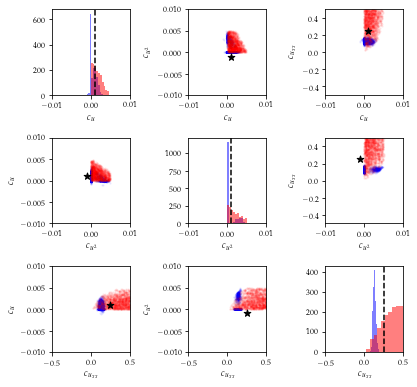

In [36]:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(6.3,6.3),gridspec_kw={'wspace':0.75,'hspace':0.5})
alpha=0.05

axes[0,0].hist(FPU_posterior[:,0],color='blue',alpha=0.5)
axes[0,0].hist(FPU_broad[:,0],color='red',alpha=0.5)
axes[0,0].axvline(0.001,color='black',linestyle='dashed')
axes[0,0].set_xlim([-0.01,0.01])
axes[0,0].set_xlabel(r'$c_u$')

axes[0,1].scatter(FPU_posterior[:,0],FPU_posterior[:,1],s=2,color='blue',alpha=alpha)
axes[0,1].scatter(FPU_broad[:,0],FPU_broad[:,1],s=2,color='red',alpha=alpha)
axes[0,1].scatter(0.001,-0.001,marker='*',color='black',s=50)
axes[0,1].set_xlabel(r'$c_u$')
axes[0,1].set_ylabel(r'$c_{u^2}$')
axes[0,1].set_xlim([-0.01,0.01])
axes[0,1].set_ylim([-0.01,0.01])

axes[0,2].scatter(FPU_posterior[:,0],FPU_posterior[:,2],s=2,color='blue',alpha=alpha)
axes[0,2].scatter(FPU_broad[:,0],FPU_broad[:,2],s=2,color='red',alpha=alpha)
axes[0,2].scatter(0.001,0.25,marker='*',color='black',s=50)
axes[0,2].set_xlabel(r'$c_u$')
axes[0,2].set_ylabel(r'$c_{u_{xx}}$')
axes[0,2].set_xlim([-0.01,0.01])
axes[0,2].set_ylim([-0.5,0.5])

axes[1,0].scatter(FPU_posterior[:,1],FPU_posterior[:,0],s=2,color='blue',alpha=alpha)
axes[1,0].scatter(FPU_broad[:,1],FPU_broad[:,0],s=2,color='red',alpha=alpha)
axes[1,0].scatter(-0.001,0.001,marker='*',color='black',s=50)
axes[1,0].set_ylabel(r'$c_u$')
axes[1,0].set_xlabel(r'$c_{u^2}$')
axes[1,0].set_xlim([-0.01,0.01])
axes[1,0].set_ylim([-0.01,0.01])
                     
axes[1,1].hist(FPU_posterior[:,1],color='blue',alpha=0.5)
axes[1,1].hist(FPU_broad[:,1],color='red',alpha=0.5)
axes[1,1].axvline(0.001,color='black',linestyle='dashed')
axes[1,1].set_xlim([-0.01,0.01])
axes[1,1].set_xlabel(r'$c_{u^2}$')

axes[1,2].scatter(FPU_posterior[:,1],FPU_posterior[:,2],s=2,color='blue',alpha=alpha)
axes[1,2].scatter(FPU_broad[:,1],FPU_broad[:,2],s=2,color='red',alpha=alpha)
axes[1,2].scatter(-0.001,0.25,marker='*',color='black',s=50)
axes[1,2].set_xlabel(r'$c_{u^2}$')
axes[1,2].set_ylabel(r'$c_{u_{xx}}$')
axes[1,2].set_xlim([-0.01,0.01])
axes[1,2].set_ylim([-0.5,0.5])

axes[2,0].scatter(FPU_posterior[:,2],FPU_posterior[:,0],s=2,color='blue',alpha=alpha)
axes[2,0].scatter(FPU_broad[:,2],FPU_broad[:,0],s=2,color='red',alpha=alpha)
axes[2,0].scatter(0.25,0.001,marker='*',color='black',s=50)
axes[2,0].set_xlabel(r'$c_{u_{xx}}$')
axes[2,0].set_ylabel(r'$c_{u}$')
axes[2,0].set_xlim([-0.5,0.5])
axes[2,0].set_ylim([-0.01,0.01])

axes[2,1].scatter(FPU_posterior[:,2],FPU_posterior[:,1],s=2,color='blue',alpha=alpha)
axes[2,1].scatter(FPU_broad[:,2],FPU_broad[:,1],s=2,color='red',alpha=alpha)
axes[2,1].scatter(0.25,-0.001,marker='*',color='black',s=50)
axes[2,1].set_xlabel(r'$c_{u_{xx}}$')
axes[2,1].set_ylabel(r'$c_{u^2}$')
axes[2,1].set_xlim([-0.5,0.5])
axes[2,1].set_ylim([-0.01,0.01])

axes[2,2].hist(FPU_posterior[:,2],color='blue',alpha=0.5)
axes[2,2].hist(FPU_broad[:,2],color='red',alpha=0.5)
axes[2,2].axvline(0.25,color='black',linestyle='dashed')
axes[2,2].set_xlim([-0.5,0.5])
axes[2,2].set_xlabel(r'$c_{u_{xx}}$')
plt.savefig('CaseIIIposteriors',dpi=1000,bbox_inches='tight')